### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

In [6]:
def get_validation_unseen_set(dataframe, validation_frac=0.05, sample=False, sample_frac=0.1):
    if not sample:
        dataset = dataframe.copy()
    else:
        dataset = dataframe.sample(frac=sample_frac)
    data = dataset.sample(frac=(1-validation_frac), random_state=786)
    data_unseen = dataset.drop(data.index)
    data.reset_index(inplace=True, drop=True)
    data_unseen.reset_index(inplace=True, drop=True)
    return data, data_unseen

In [7]:
data_for_model, data_unseen = get_validation_unseen_set(dataset, validation_frac=0.05, sample=False, sample_frac=0.1)
print('Data for Modeling: ' + str(data_for_model.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (227016, 12)
Unseen Data For Predictions: (11948, 12)


### 3 Setting up Environment: 

In [8]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

import sqlite3
import os

In [9]:
# Define the path where you want to store the database
db_folder = './'
db_name = 'lead_scoring_model_experimentation.db'


In [10]:
import sqlite3
from sqlite3 import Error

def create_sqlit_connection(db_path,db_file):
    """ create a database connection to a SQLite database """
    conn = None
    # opening the conncetion for creating the sqlite db
    try:
        os.makedirs(db_path, exist_ok=True)
        db_full_path = os.path.join(db_path, db_file)    
        conn = sqlite3.connect(db_full_path)
        print(sqlite3.version)
    # return an error if connection not established
    except Error as e:
        print(e)
    # closing the connection once the database is created
    finally:
        if conn:
            conn.close()

In [11]:
create_sqlit_connection(db_folder,r"lead_scoring_model_experimentation.db")

2.6.0


In [12]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [13]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"

In [14]:
import mlflow

In [15]:
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [16]:
# setup pycaret 
from pycaret.classification import *

In [30]:
# No Pre-Processing 
Baseline_model_exp01 = setup(data = data_for_model, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp01',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(227016, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [31]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7393,0.8210,0.8344,0.7029,0.7630,0.4779,0.4867,0.6120
lightgbm,Light Gradient Boosting Machine,0.7392,0.8212,0.8360,0.7022,0.7633,0.4777,0.4868,4.7660
et,Extra Trees Classifier,0.7370,0.8171,0.8192,0.7054,0.7581,0.4734,0.4798,3.2160
dt,Decision Tree Classifier,0.7369,0.8164,0.8189,0.7054,0.7579,0.4732,0.4795,0.4420
rf,Random Forest Classifier,0.7350,0.8169,0.8458,0.6941,0.7625,0.4692,0.4810,1.3480
lr,Logistic Regression,0.7116,0.7849,0.8231,0.6749,0.7417,0.4223,0.4331,0.2540
ridge,Ridge Classifier,0.7013,0.0000,0.7974,0.6708,0.7287,0.4018,0.4093,0.1660
lda,Linear Discriminant Analysis,0.7013,0.7746,0.7974,0.6708,0.7287,0.4018,0.4093,0.9720
nb,Naive Bayes,0.6646,0.7344,0.8795,0.6169,0.7251,0.3274,0.3627,0.2020


In [32]:
# create a model which gives the highest accuracy
lightgbm = create_model('lightgbm')

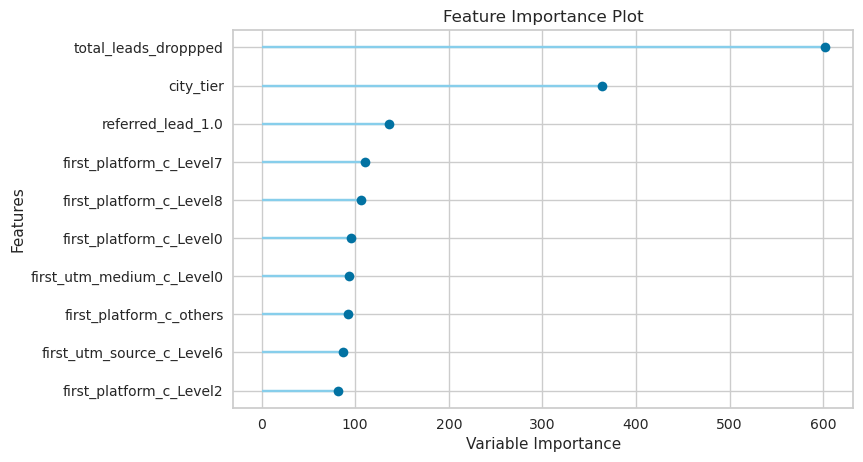

In [33]:
# create feature importance plot
plot_model(lightgbm, plot='feature')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [34]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

cols = ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
dataset_cols = dataset[cols]

In [35]:
from pycaret.classification import *

exp_lead_scoring = setup(data=dataset_cols, target = 'app_complete_flag',  
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   categorical_features = ['city_tier', 'first_platform_c','first_utm_medium_c', 'first_utm_source_c'],
                   fold_shuffle=True, 
                   session_id = 42,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Lead_scoring_model_experiment_02',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=True)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [36]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 10,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8325,0.7025,0.7620,0.4764,0.4849,1.2340
xgboost,Extreme Gradient Boosting,0.7382,0.8211,0.8306,0.7027,0.7613,0.4758,0.4840,9.3660
rf,Random Forest Classifier,0.7368,0.8186,0.8232,0.7037,0.7588,0.4731,0.4802,2.0390
et,Extra Trees Classifier,0.7364,0.8178,0.8204,0.7042,0.7579,0.4723,0.4790,2.4940
dt,Decision Tree Classifier,0.7363,0.8172,0.8202,0.7041,0.7577,0.4720,0.4787,0.1410
lr,Logistic Regression,0.7097,0.7841,0.8219,0.6731,0.7401,0.4187,0.4294,0.5550
ridge,Ridge Classifier,0.6998,0.0000,0.7960,0.6695,0.7272,0.3989,0.4064,0.0630
lda,Linear Discriminant Analysis,0.6998,0.7733,0.7959,0.6695,0.7272,0.3989,0.4063,0.4170
nb,Naive Bayes,0.6732,0.7337,0.8569,0.6284,0.7250,0.3451,0.3709,0.0600


In [37]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lightgbm_fs = create_model('lightgbm')

In [38]:
model_config_without_hp = lightgbm_fs.get_params()

In [39]:
!pip install optuna

In [40]:
pip install optuna-integration

Note: you may need to restart the kernel to use updated packages.


In [41]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
from pycaret.classification import tune_model
import optuna

param_distributions = {
    'actual_estimator__num_leaves': optuna.distributions.IntDistribution(20, 50)
}
# Now, you can use the tune_model function with the updated custom_grid parameter
tuned_lgbm_optuna, tuner_1 = tune_model(lightgbm_fs, 
                                        search_library='optuna',
                                        fold=10,
                                        optimize='auc',
                                        choose_better=True,
                                        return_tuner=True,
                                        custom_grid=param_distributions)





In [42]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lgbm_optuna.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 47, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


/opt/conda/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/conda/lib